
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>



# Постановка задачи

Необходимо классифицировать персонажей, проживающих в Спрингфилде (990 картинок).


# Установка зависимостей



In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle competitions download -c journey-springfield

journey-springfield.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Apr 19 18:09:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             31W /   70W |    3934MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

# Библиотеки

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# пакет для проверки версий других пакетов
import pkg_resources

In [ ]:
!python --version

Python 3.11.12


In [ ]:
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ pkg_resources.get_distribution(b).version)

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
tqdm version: 4.67.1
matplotlib version: 3.10.0
seaborn version: 0.13.2
Pillow version: 11.1.0


## Версии питона и библиотек, на которых работал ноутбук:

Python 3.11.11

torch version: 2.5.1+cu124

torchvision version: 0.20.1+cu124

tqdm version: 4.67.1

matplotlib version: 3.10.0

seaborn version: 0.13.2

Pillow version: 11.1.0


# Работа с датасетом

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # Преобразование изображений в тензоры PyTorch и нормализация входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# Директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

## Примеры объектов датасета

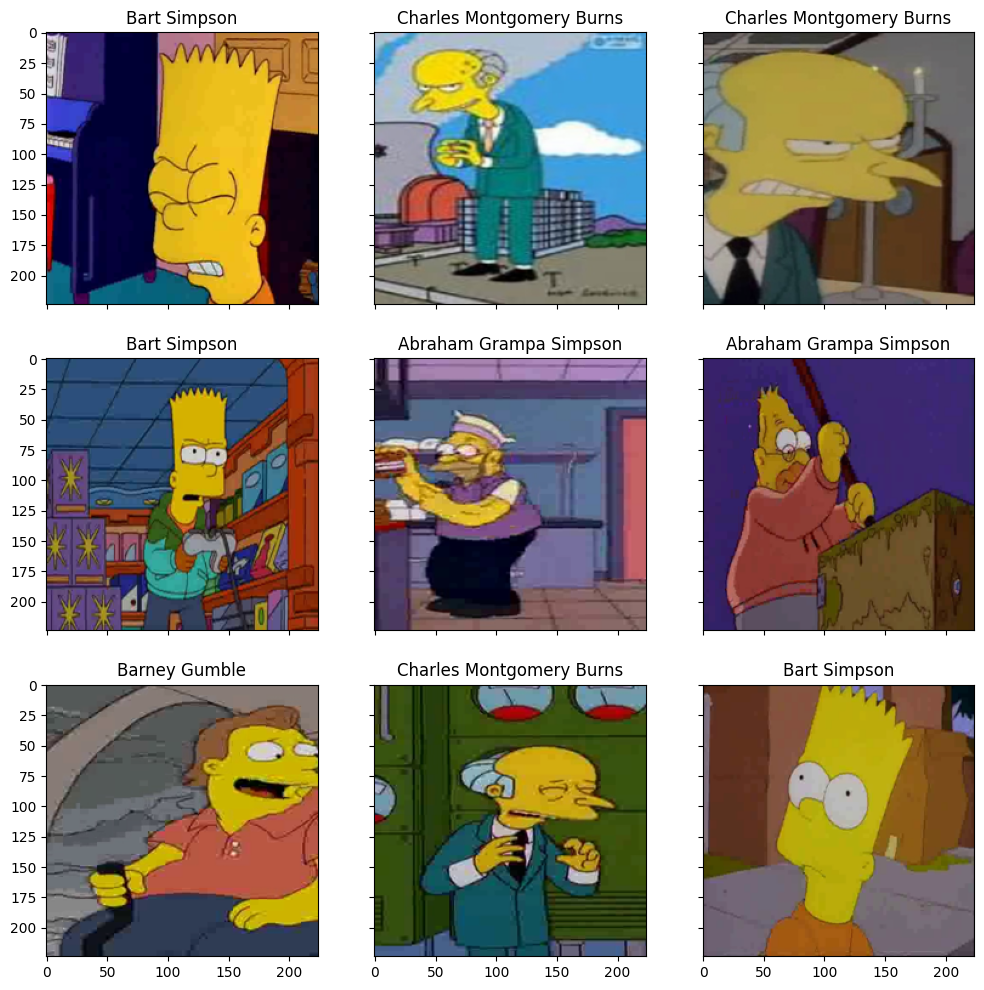

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Построение нейросети

## Функция обучения:

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Обучение модели на одной эпохе.

    Параметры:
    ----------
    model : nn.Module - модель
    train_loader : DataLoader - загрузчик данных
    criterion : nn.Module - функция потерь
    optimizer : torch.optim.Optimizer - оптимизатор
    """

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

## Функция валидации:

In [ ]:
def eval_epoch(model, val_loader, criterion):
    """
    Функция оценивает работу модели на валидационном наборе данных за одну эпоху.

    Параметры:
    ----------
    model : nn.Module - модель
    val_loader : DataLoader - загрузчик данных
    criterion : nn.Module - функция потерь
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

## Полный цикл обучения

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    """
    Обучение модели на обучающем наборе данных и оценка на валидационном наборе данных.

    Параметры:
    ----------
    train_files : list - список файлов обучающей выборки
    val_files : list - список файлов валидационной выборки
    model : nn.Module - модель
    epochs : int - число эпох обучения
    batch_size : int - размер батча
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    """
    Предсказание классов для тестового набора данных с использованием обученной модели.

    Параметры:
    ----------
    model : nn.Module - модель
    test_loader : DataLoader - загрузчик данных
    """

    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

# Аугментация

In [ ]:
len(train_dataset)

15699

In [ ]:
from torchvision.transforms import v2

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(0)

hflipper = v2.RandomHorizontalFlip(p=0.8)
transformed_imgs = hflipper(train_dataset)
aug_dataset = train_dataset + transformed_imgs

In [ ]:
len(aug_dataset)

31398

# Transfer Learning

In [ ]:
from torchvision import models

model_extractor = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_extractor

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
n_classes = len(np.unique(train_val_labels))

In [ ]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

In [ ]:
# на последнем слое fc с in_features = 512, out_features = 1000. Сделаем замену на fc(512, n_classes)
model_extractor.fc = nn.Linear(512, n_classes)

In [ ]:
# Обучаем только классификатор
import torch.optim as optim

optimizer = optim.Adam(model_extractor.fc.parameters(), lr=1e-3)

In [ ]:
model_extractor = model_extractor.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model_extractor, epochs=25, batch_size=128)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 2.4117712185818556


epoch:   4%|▍         | 1/25 [02:07<51:06, 127.77s/it]


Epoch 001 train_loss: 2.4118     val_loss 1.7621 train_acc 0.4086 val_acc 0.6288
loss 1.5110474481530398


epoch:   8%|▊         | 2/25 [04:12<48:17, 125.99s/it]


Epoch 002 train_loss: 1.5110     val_loss 1.3472 train_acc 0.6617 val_acc 0.6840
loss 1.2154931811376988


epoch:  12%|█▏        | 3/25 [06:16<45:53, 125.14s/it]


Epoch 003 train_loss: 1.2155     val_loss 1.1590 train_acc 0.7103 val_acc 0.7159
loss 1.05435884214904


epoch:  16%|█▌        | 4/25 [08:21<43:47, 125.11s/it]


Epoch 004 train_loss: 1.0544     val_loss 1.0640 train_acc 0.7425 val_acc 0.7291
loss 0.9592344853990252


epoch:  20%|██        | 5/25 [10:25<41:35, 124.79s/it]


Epoch 005 train_loss: 0.9592     val_loss 1.0005 train_acc 0.7587 val_acc 0.7394
loss 0.8872208808461484


epoch:  24%|██▍       | 6/25 [12:30<39:27, 124.60s/it]


Epoch 006 train_loss: 0.8872     val_loss 0.9432 train_acc 0.7767 val_acc 0.7497
loss 0.8324917925870436


epoch:  28%|██▊       | 7/25 [14:35<37:25, 124.74s/it]


Epoch 007 train_loss: 0.8325     val_loss 0.9127 train_acc 0.7856 val_acc 0.7560
loss 0.7888390761179881


epoch:  32%|███▏      | 8/25 [16:39<35:18, 124.61s/it]


Epoch 008 train_loss: 0.7888     val_loss 0.8894 train_acc 0.7974 val_acc 0.7606
loss 0.7552663145820703


epoch:  36%|███▌      | 9/25 [18:43<33:11, 124.49s/it]


Epoch 009 train_loss: 0.7553     val_loss 0.8730 train_acc 0.8030 val_acc 0.7702
loss 0.7256608634809376


epoch:  40%|████      | 10/25 [20:48<31:08, 124.54s/it]


Epoch 010 train_loss: 0.7257     val_loss 0.8618 train_acc 0.8116 val_acc 0.7677
loss 0.6987427390869335


epoch:  44%|████▍     | 11/25 [22:52<29:02, 124.43s/it]


Epoch 011 train_loss: 0.6987     val_loss 0.8404 train_acc 0.8195 val_acc 0.7732
loss 0.6778655882299048


epoch:  48%|████▊     | 12/25 [24:56<26:57, 124.40s/it]


Epoch 012 train_loss: 0.6779     val_loss 0.8319 train_acc 0.8217 val_acc 0.7730
loss 0.6593240729501516


epoch:  52%|█████▏    | 13/25 [27:02<24:56, 124.68s/it]


Epoch 013 train_loss: 0.6593     val_loss 0.8226 train_acc 0.8264 val_acc 0.7765
loss 0.6399234997496437


epoch:  56%|█████▌    | 14/25 [29:06<22:51, 124.68s/it]


Epoch 014 train_loss: 0.6399     val_loss 0.8219 train_acc 0.8327 val_acc 0.7747
loss 0.6280689227352462


epoch:  60%|██████    | 15/25 [31:11<20:46, 124.61s/it]


Epoch 015 train_loss: 0.6281     val_loss 0.8052 train_acc 0.8323 val_acc 0.7830
loss 0.6131388389598762


epoch:  64%|██████▍   | 16/25 [33:17<18:44, 124.96s/it]


Epoch 016 train_loss: 0.6131     val_loss 0.8033 train_acc 0.8361 val_acc 0.7820
loss 0.5983488820633225


epoch:  68%|██████▊   | 17/25 [35:22<16:39, 124.97s/it]


Epoch 017 train_loss: 0.5983     val_loss 0.8044 train_acc 0.8437 val_acc 0.7812
loss 0.5855603809701887


epoch:  72%|███████▏  | 18/25 [37:26<14:33, 124.74s/it]


Epoch 018 train_loss: 0.5856     val_loss 0.7910 train_acc 0.8448 val_acc 0.7805
loss 0.5741161704101383


epoch:  76%|███████▌  | 19/25 [39:31<12:29, 124.84s/it]


Epoch 019 train_loss: 0.5741     val_loss 0.7971 train_acc 0.8475 val_acc 0.7809
loss 0.5659434824728253


epoch:  80%|████████  | 20/25 [41:35<10:23, 124.68s/it]


Epoch 020 train_loss: 0.5659     val_loss 0.8002 train_acc 0.8492 val_acc 0.7768
loss 0.5568596960951685


epoch:  84%|████████▍ | 21/25 [43:40<08:18, 124.62s/it]


Epoch 021 train_loss: 0.5569     val_loss 0.7932 train_acc 0.8516 val_acc 0.7793
loss 0.5437488394244036


epoch:  88%|████████▊ | 22/25 [45:45<06:14, 124.75s/it]


Epoch 022 train_loss: 0.5437     val_loss 0.7841 train_acc 0.8554 val_acc 0.7824


In [ ]:
# кривые обучения
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# размораживаем веса
for param in model_extractor.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model_extractor.parameters(), lr=1e-4)

In [ ]:
history = train(train_dataset, val_dataset, model_extractor, epochs=10, batch_size=128)

In [ ]:
# кривые обучения
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model_extractor, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

In [ ]:
# тестирование
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model_extractor, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
my_submit.to_csv('resnet18_new.csv', index=False)

In [ ]:
!kaggle competitions submit journey-springfield -f resnet18_new.csv -m "resnet18"

На kaggle попытка называется resnet18, f1-score: 0.95111


team_name: Софья_Ногина_299953517